# Approximation of a time-dependent 3D bubble shape

## Outline

1. [Starting point](#starting_point)
2. [Parameterization](#parameterization)
3. [Training, validation, and test data](#data_splitting)
4. [Simple function approximation](#function_approximation)
5. [Model training](#model_training)
6. [Testing the model](#model_test)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>

- approximate r(phi, theta, t)
- moving reference frame data, include animation

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn as sk
from sklearn.model_selection import train_test_split
import torch
from helper_module import SimpleMLP, approximate_function
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    import urllib
    import cloudpickle as cp
else:
    import pickle
    matplotlib.rcParams['figure.dpi'] = 80
    
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))
print("Sklearn version: {}".format(sk.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))
print("Executing PyTorch operations using {}.".format(device))

Pandas version: 0.24.2
Numpy version: 1.14.2
PyTorch version: 0.4.1
Sklearn version: 0.19.1
Running notebook locally.
Executing PyTorch operations using cpu.


In [2]:
if not IN_COLAB:
    data_file = "../data/3mm_l12_shape.pkl"
    with open(data_file, 'rb') as file:
        data = pickle.load(file)
else:
    data_file = "https://github.com/AndreWeiner/machine-learning-applied-to-cfd/blob/master/data/3mm_l12_shape.pkl?raw=true"
    response = urllib.request.urlopen(data_file)
    data = cp.load(response)

print("The data set contains {} points.".format(data.shape[0]))
data.sample(10)

The data set contains 1168729 points.


,x,y,z,t
502975,0.145769,-0.252371,-0.322906,2.246696
159599,-0.117102,-0.312175,0.352097,0.727417
783689,-0.534774,0.022501,0.430004,3.480176
877898,-0.413278,0.076476,-0.539686,3.876652
609259,-0.583961,0.133723,-0.119016,2.753304
666974,-0.149586,0.263868,0.055825,2.973568
1152123,-0.552428,0.178672,0.241883,5.000000
1052589,-0.452614,-0.177530,0.139817,4.603524
224426,-0.492650,-0.176557,0.117226,1.035242
179621,-0.117104,0.325771,-0.322207,0.815347


## Parameterization<a id="parameterization"></a>

In [3]:
def spherical_coordinates(px, py, pz):
    '''Converts Cartesian coordinates x, y, z to spherical coordinates r, phi, theta.
    
    Parameters
    ----------
    px, py, pz - array-like: x, y, and z coordinates
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like   : polar angle
    theta - array-like : azimuth angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py) + np.square(pz))
    phi = np.where(px >= 0, np.arccos(py / radius), 2.0 * np.pi - np.arccos(py / radius))
    theta = (np.arctan2(px, pz) + np.pi) % np.pi
    return radius, phi, theta


def cartesian_coordinates(radius, phi, theta):
    '''Converts spherical coordinates r, phi, theta to Cartesian coordinates x, y, z.
    
    Parameters
    ----------
    radius, phi, theta - array-like: radius, polar angle, and azimuth angle
    
    Returns
    -------
    x, y, z - array-like : Cartesian coordinates
    
    '''
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.cos(phi)
    z = radius * np.sin(phi) * np.sin(theta)
    return x, y, z

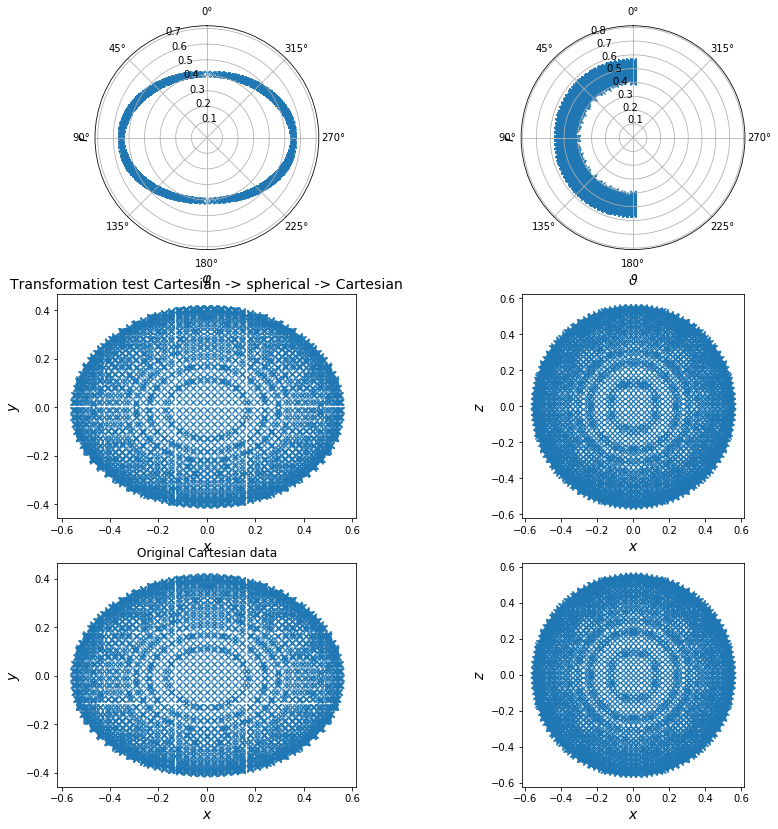

In [59]:
test_time = data.sample(1).t.values[0]
test_data = data[data.t == test_time]

%matplotlib inline
fontsize = 14

fig = plt.figure(figsize=(14,14))
ax1 = plt.subplot(321, projection='polar')
ax2 = plt.subplot(322, projection='polar')
ax3 = plt.subplot(323)
ax4 = plt.subplot(324)
ax5 = plt.subplot(325)
ax6 = plt.subplot(326)

rad, phi, theta = spherical_coordinates(test_data.x.values, test_data.y.values, test_data.z.values)
x, y, z = cartesian_coordinates(rad, phi, theta)

ax1.set_theta_zero_location("N")
ax1.scatter(phi, rad, marker='x', color='C0', s=30, linewidth=0.5)
ax1.set_xlim(0.0, 2.0*np.pi)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.set_theta_zero_location("N")
ax2.scatter(theta, rad, marker='x', color='C0', s=30, linewidth=0.5)
ax1.set_xlim(0.0, 2.0*np.pi)
ax2.set_xlabel(r"$\vartheta$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)

ax3.scatter(x, y, marker='x', color='C0', s=30, linewidth=0.5)
ax3.set_xlabel(r"$x$", fontsize=fontsize)
ax3.set_ylabel(r"$y$", fontsize=fontsize)
ax3.set_aspect('equal')
ax3.set_title(r"Transformation test Cartesian -> spherical -> Cartesian", fontsize=fontsize)

ax4.scatter(x, z, marker='x', color='C0', s=30, linewidth=0.5)
ax4.set_xlabel(r"$x$", fontsize=fontsize)
ax4.set_ylabel(r"$z$", fontsize=fontsize)
ax4.set_aspect('equal')

ax5.scatter(test_data.x.values, test_data.y.values, marker='x', color='C0', s=30, linewidth=0.5)
ax5.set_xlabel(r"$x$", fontsize=fontsize)
ax5.set_ylabel(r"$y$", fontsize=fontsize)
ax5.set_aspect('equal')
ax5.set_title(r"Original Cartesian data")

ax6.scatter(test_data.x.values, test_data.z.values, marker='x', color='C0', s=30, linewidth=0.5)
ax6.set_xlabel(r"$x$", fontsize=fontsize)
ax6.set_ylabel(r"$z$", fontsize=fontsize)
ax6.set_aspect('equal')
    
plt.show()

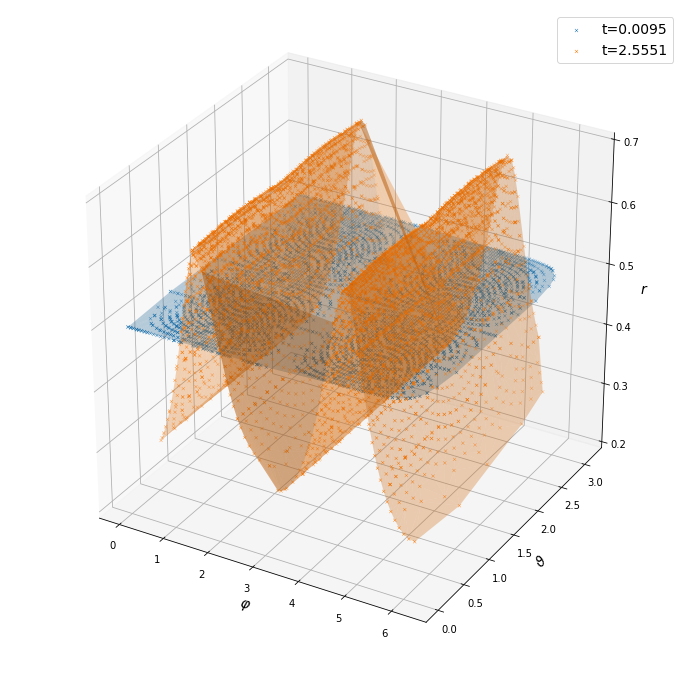

In [60]:
every_instance = 25
times = sorted(data['t'].unique())[::every_instance]

every = 4
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colors = ["C{:1d}".format(i) for i in range(len(times))]

for i, t in enumerate(times):
    data_temp = data[data.t == t]
    rad_t, phi_t, theta_t = spherical_coordinates(data_temp.x.values, data_temp.y.values, data_temp.z.values)
    ax.scatter(phi_t[::every], theta_t[::every], rad_t[::every],
               marker='x', color=colors[i], s=10, linewidth=0.5, label=r"t={:2.4f}".format(t))
    ax.plot_trisurf(phi_t[::every], theta_t[::every], rad_t[::every], color=colors[i], alpha=0.3)

ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$\vartheta$", fontsize=fontsize)
ax.set_zlabel(r"$r$", fontsize=fontsize)
ax.set_zlim(0.2, 0.7)
plt.legend(fontsize=fontsize)
plt.show()

## Using an ellipsoidal base shape to simplify the learning problem<a id="ellipsoidal_base_shape"></a>

In [64]:
def estimate_half_axis(x, y, z):
    ''' Estimate the half axis of an ellipsoid from a point cloud.
    
    Parameters
    ----------
    x, y, z - array-like : Cartesian coordinates
    
    Returns
    -------
    a, b, c - Float : half axis of the ellipsoid
    
    '''
    a = 0.5 * (np.amax(x) - np.amin(x))
    b = 0.5 * (np.amax(y) - np.amin(y))
    c = 0.5 * (np.amax(z) - np.amin(z))
    return a, b, c
    
    
def ellipsoidal_radius(phi, theta, t, axis_model):
    '''Compute the radius of an ellipsoid with instantaneous half axis.
    
    Parameters
    ----------
    phi, theta - array-like : polar and azimuth angle
    t - array-like          : time
    axis_model - SimpleMLP  : PyTorch model to compute instantaneous half axis
    
    Returns
    -------
    radius - array-like : instantaneous ellipsoidal radius
    
    '''
    t_tensor = torch.from_numpy(t.astype(np.float32))
    a, b, c = axis_model(t_tensor).detach().numpy().T
    radius = np.sqrt(np.square(a * np.sin(phi) * np.cos(theta))
                   + np.square(b * np.cos(phi))
                   + np.square(c * np.sin(phi) * np.sin(theta)))
    return radius

In [7]:
half_axis = []
for time in data["t"].unique():
    data_t = data[data.t == time]
    xt, yt, zt = data_t.x.values, data_t.y.values, data_t.z.values
    half_axis.append(estimate_half_axis(xt, yt, zt))
half_axis = np.asarray(half_axis)

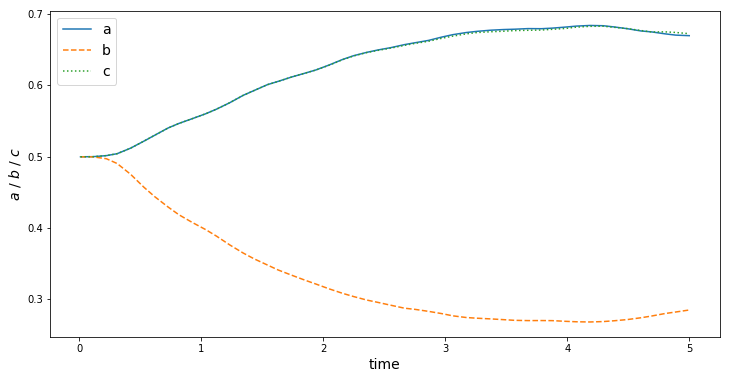

In [8]:
# plot half axis over time
plt.figure(figsize=(12, 6))
plt.plot(data.t.unique(), half_axis[:,0], c="C0", linestyle='-', label="a")
plt.plot(data.t.unique(), half_axis[:,1], c="C1", linestyle='--', label="b")
plt.plot(data.t.unique(), half_axis[:,2], c="C2", linestyle=':', label="c")
plt.xlabel(r"time", fontsize=fontsize)
plt.ylabel(r"$a$ / $b$ / $c$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [9]:
def set_path(name=None):
    if IN_COLAB:
        return F"/content/gdrive/My Drive/" + name
    else:
        return "models/" + name

In [49]:
axis_model = SimpleMLP(n_inputs=1, n_outputs=3, n_layers=2, n_neurons=10, activation=torch.sigmoid, batch_norm=False)
X_train, X_val, axis_train, axis_val = train_test_split(data.t.unique().reshape(-1, 1), half_axis, test_size=0.1, random_state=42)
axis_model, train_loss, val_loss = approximate_function(X_train, axis_train, X_val, axis_val, axis_model, max_iter=10000,
                                            l_rate=0.01, batch_size=100, path=set_path("3mm_axis_model.pt"), device='cpu', verbose=1000)

Created model with 163 weights.
Training loss decreased in epoch 1029: 2.6616573450155556e-05
Validation loss/max. dev.: 1.695572427706793e-05/0.007284045219421387
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 2029: 1.8995577192981727e-05
Validation loss/max. dev.: 1.0573105100775138e-05/0.005852222442626953
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 3110: 1.5897428966127336e-05
Validation loss/max. dev.: 7.347823157033417e-06/0.004468142986297607
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 4511: 1.0867097444133833e-05
Validation loss/max. dev.: 3.6143983379588462e-06/0.0033774077892303467
--------------------------------
Saving model as models/3mm_axis_model.pt
Training loss decreased in epoch 5930: 5.844517545483541e-06
Validation loss/max. dev.: 8.408945859628147e-07/0.0018355250358581543
---------

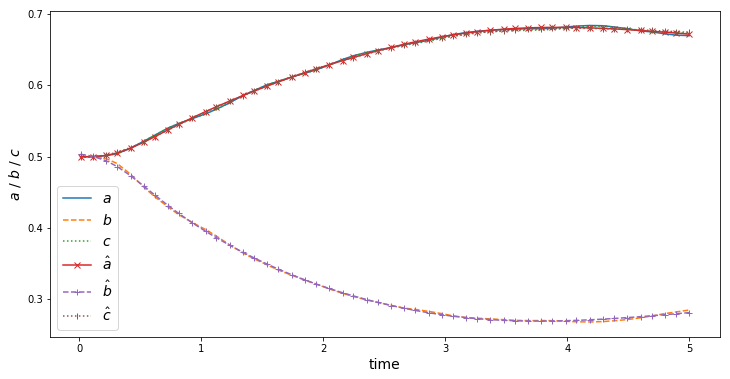

In [50]:
axis_model.load_state_dict(torch.load(set_path("3mm_axis_model.pt")))
a_model, b_model, c_model = axis_model(torch.from_numpy(data.t.unique().reshape(-1, 1).astype(np.float32))).detach().numpy().T

# plot deviation over time
plt.figure(figsize=(12, 6))
plt.plot(data.t.unique(), half_axis[:,0], c="C0", linestyle='-', label=r"$a$")
plt.plot(data.t.unique(), half_axis[:,1], c="C1", linestyle='--', label=r"$b$")
plt.plot(data.t.unique(), half_axis[:,2], c="C2", linestyle=':', label=r"$c$")
plt.plot(data.t.unique(), a_model, c="C3", linestyle='-', marker='x', label="$\hat{a}$")
plt.plot(data.t.unique(), b_model, c="C4", linestyle='--', marker='+', label="$\hat{b}$")
plt.plot(data.t.unique(), c_model, c="C5", linestyle=':', marker='|', label="$\hat{c}$")
plt.xlabel(r"time", fontsize=fontsize)
plt.ylabel(r"$a$ / $b$ / $c$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [71]:
rad, phi, theta = spherical_coordinates(data.x.values, data.y.values, data.z.values)
radius_ellipsoid = ellipsoidal_radius(phi, theta, data.t.values.reshape(-1, 1), axis_model)
radius_scaled = rad / radius_ellipsoid
radius_scaled_01 = (radius_scaled - np.amin(radius_scaled)) / (np.amax(radius_scaled) - np.amin(radius_scaled))

print("Mean/stdev of original radius: {:2.4f}/{:2.4f}".format(np.mean(rad), np.std(rad)))
print("Mean/stdev of rescaled radius: {:2.4f}/{:2.4f}".format(np.mean(radius_scaled), np.std(radius_scaled)))
print("Mean/stdev of rescaled radius [0,1]: {:2.4f}/{:2.4f}".format(np.mean(radius_scaled_01), np.std(radius_scaled_01)))

Mean/stdev of original radius: 0.5306/0.0938
Mean/stdev of rescaled radius: 0.9090/0.0965
Mean/stdev of rescaled radius [0,1]: 0.5867/0.1877


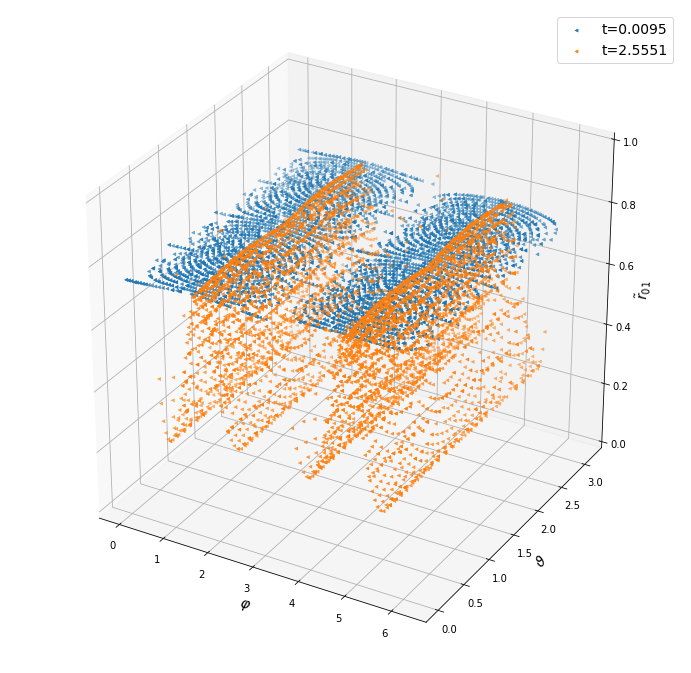

In [85]:
every_instance = 25
times = sorted(data['t'].unique())[::every_instance]

every = 4
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colors = ["C{:1d}".format(i) for i in range(len(times))]

data["rad_01"] = radius_scaled_01

for i, t in enumerate(times):
    data_temp = data[data.t == t]
    rad_t, phi_t, theta_t = spherical_coordinates(data_temp.x.values, data_temp.y.values, data_temp.z.values)
    ax.scatter(phi_t[::every], theta_t[::every], data_temp.rad_01.values[::every],
               marker='<', color=colors[i], s=10, linewidth=0.5, label=r"t={:2.4f}".format(t))
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$\vartheta$", fontsize=fontsize)
ax.set_zlabel(r"$\tilde{r}_{01}$", fontsize=fontsize)
ax.set_zlim(0.0, 1.0)
plt.legend(fontsize=fontsize)
plt.show()

## Training, validation, and test data<a id="data_splitting"></a>

In [136]:
#phi_01 = (phi - np.amin(phi)) / (np.amax(phi) - np.amin(phi))
#theta_01 = (theta - np.amin(theta)) / (np.amax(theta) - np.amin(theta))
#t_01 = (data.t.values - np.amin(data.t.values)) / (np.amax(data.t.values) - np.amin(data.t.values))

X = np.vstack([phi, theta, data.t.values]).T
#X = np.vstack([phi_01, theta_01, t_01]).T
X_train, X_tv, r_train, r_tv = train_test_split(X, data.rad_01.values, test_size=0.2, random_state=42)
X_val, X_test, r_val, r_test = train_test_split(X_tv, r_tv, test_size=0.5, random_state=42)

print("The training set contains {} points.".format(X_train.shape[0]))
print("The validation set contains {} points.".format(X_val.shape[0]))
print("The test set contains {} points.".format(X_test.shape[0]))

The training set contains 934983 points.
The validation set contains 116873 points.
The test set contains 116873 points.


## Simple function approximation<a id="function_approximation"></a>

In [141]:
radius_model = SimpleMLP(n_inputs=3, n_outputs=1, n_layers=8, n_neurons=40, activation=torch.relu, batch_norm=False)
radius_model, train_loss, val_loss = approximate_function(X_train, r_train, X_val, r_val, radius_model, max_iter=100,
                                            l_rate=0.001, batch_size=20000, path=set_path("3mm_radius_model.pt"), device=device, verbose=1)

Created model with 11681 weights.
Training loss decreased in epoch 1: 0.14161733046491096
Validation loss/max. dev.: 0.043776318430900574/0.7464262247085571
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 2: 0.03642138973512548
Validation loss/max. dev.: 0.03057263419032097/0.578273594379425
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 3: 0.027854669046528797
Validation loss/max. dev.: 0.026000531390309334/0.5152904987335205
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 4: 0.025493334067311694
Validation loss/max. dev.: 0.024995122104883194/0.49251148104667664
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 5: 0.024261073783991186
Validation loss/max. dev.: 0.023175029084086418/0.5114067792892456
--------------------------------
Saving model

Training loss decreased in epoch 85: 0.0002595801203650363
Validation loss/max. dev.: 0.00021790705795865506/0.2754594683647156
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 92: 0.0002547984446171037
Validation loss/max. dev.: 0.0002238720771856606/0.2561226487159729
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 94: 0.00023602904439804718
Validation loss/max. dev.: 0.00024413516803178936/0.25052791833877563
--------------------------------
Saving model as models/3mm_radius_model.pt
Training loss decreased in epoch 96: 0.00022048239863695616
Validation loss/max. dev.: 0.00018520439334679395/0.25079548358917236
--------------------------------
Saving model as models/3mm_radius_model.pt


L_2/L_max on test data set: 0.0002/0.2482


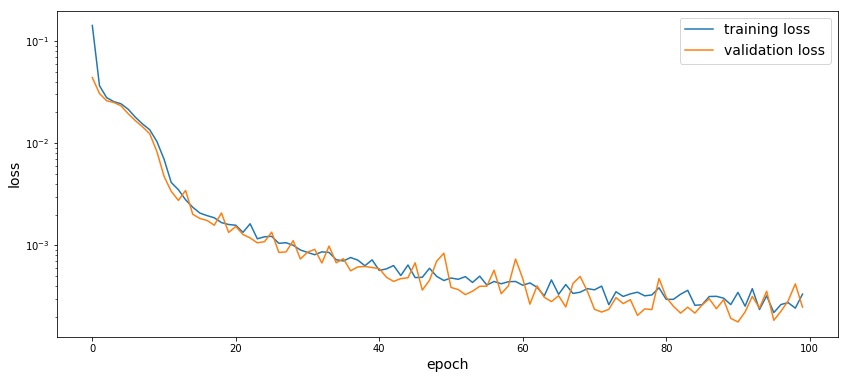

In [142]:
radius_model.load_state_dict(torch.load(set_path("3mm_radius_model.pt")))
X_test_tensor = torch.from_numpy(X_test.astype(np.float32))
r01_test_model = np.squeeze(radius_model(X_test_tensor).detach().numpy())
err_test = np.absolute(r_test - r01_test_model)
print("L_2/L_max on test data set: {:2.4f}/{:2.4f}".format(np.mean(np.square(err_test)), np.amax(err_test)))

plt.figure(figsize=(14,6))
plt.semilogy(range(len(train_loss)), train_loss, label=r"training loss")
plt.semilogy(range(len(val_loss)),  val_loss, label=r"validation loss")
plt.xlabel(r"epoch", fontsize=fontsize)
plt.ylabel(r"loss", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [143]:
X_tensor = torch.from_numpy(X.astype(np.float32))
r01_model = np.squeeze(radius_model(X_tensor).detach().numpy())
rad_model = (r01_model * (np.amax(radius_scaled) - np.amin(radius_scaled)) + np.amin(radius_scaled)) * radius_ellipsoid
err_full = np.absolute(rad - rad_model)
print(np.amax(err_full), np.mean(err_full), np.argmax(err_full))

0.03766316 0.0027879653 1161289


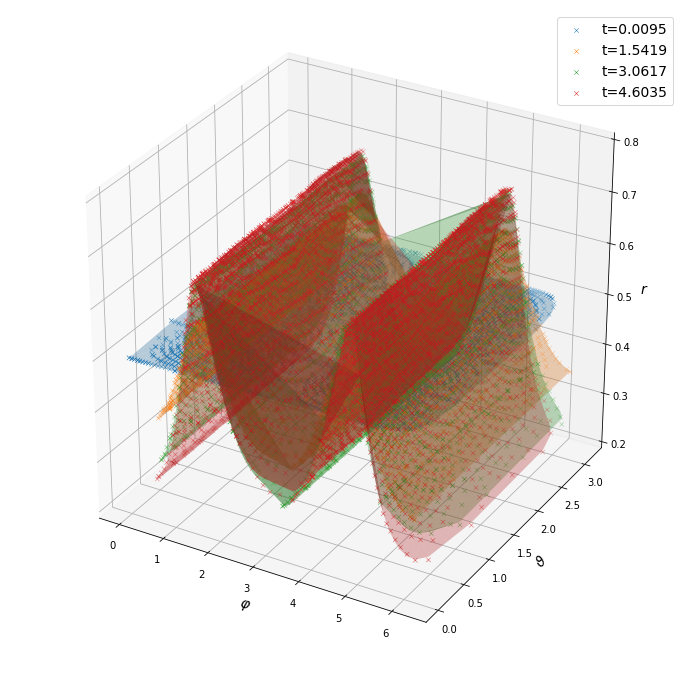

In [147]:
#### plot as contours!!!!!

every_instance = 15
times = sorted(data['t'].unique())[::every_instance]

every = 4
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
colors = ["C{:1d}".format(i) for i in range(len(times))]

data["rad_m"] = rad_model
data["rad_el"] = radius_ellipsoid

for i, t in enumerate(times):
    data_temp = data[data.t == t]
    rad_t, phi_t, theta_t = spherical_coordinates(data_temp.x.values, data_temp.y.values, data_temp.z.values)
    #ax.scatter(phi_t[::every], theta_t[::every], rad_t[::every],
    #           marker='x', color=colors[i], s=10, linewidth=0.5, label=r"t={:2.4f}".format(t))
    ax.scatter(phi_t[::every], theta_t[::every], data_temp.rad_m.values[::every],
               marker='x', color=colors[i], s=20, linewidth=0.5, label=r"t={:2.4f}".format(t))
    #ax.scatter(phi_t[::every], theta_t[::every], data_temp.rad_el.values[::every],
    #           marker='<', color=colors[i], s=10, linewidth=0.5, label=r"t={:2.4f}".format(t))
    ax.plot_trisurf(phi_t[::every], theta_t[::every], rad_t[::every], color=colors[i], alpha=0.3)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$\vartheta$", fontsize=fontsize)
ax.set_zlabel(r"$r$", fontsize=fontsize)
ax.set_zlim(0.2, 0.8)
plt.legend(fontsize=fontsize)
plt.show()

## Model training<a id="model_training"></a>

Iteration 0
------------
Testing 8 layers with 60 neurons...
Created model with 25921 weights.
Minimal training/validation loss: 6.3464e-06/6.0591e-06
Validation loss decreased to 6.0591e-06. Saving model.

Iteration 1
------------
Testing 7 layers with 20 neurons...
Created model with 2621 weights.
Minimal training/validation loss: 1.7418e-05/1.7457e-05

Iteration 2
------------
Testing 9 layers with 20 neurons...
Created model with 3461 weights.
Minimal training/validation loss: 1.4328e-05/1.4129e-05

Iteration 3
------------
Testing 8 layers with 40 neurons...
Created model with 11681 weights.
Minimal training/validation loss: 6.9839e-06/6.6894e-06

Iteration 4
------------
Testing 5 layers with 20 neurons...
Created model with 1781 weights.
Minimal training/validation loss: 2.5385e-05/2.5161e-05

Iteration 5
------------
Testing 1 layers with 50 neurons...
Created model with 251 weights.
Minimal training/validation loss: 2.8046e-04/2.8044e-04

Iteration 6
------------
Testing 2 lay

Minimal training/validation loss: 4.2714e-06/4.2231e-06
Validation loss decreased to 4.2231e-06. Saving model.

Iteration 49
------------
Testing 7 layers with 50 neurons...
Created model with 15551 weights.
Minimal training/validation loss: 8.5616e-06/7.8549e-06

Iteration 50
------------
Testing 7 layers with 20 neurons...
Created model with 2621 weights.
Minimal training/validation loss: 6.9377e-05/6.9727e-05

Iteration 51
------------
Testing 6 layers with 10 neurons...
Created model with 601 weights.
Minimal training/validation loss: 4.8043e-05/4.7361e-05

Iteration 52
------------
Testing 2 layers with 70 neurons...
Created model with 5321 weights.
Minimal training/validation loss: 2.2921e-05/2.2465e-05

Iteration 53
------------
Testing 8 layers with 70 neurons...
Created model with 35141 weights.
Minimal training/validation loss: 4.8981e-06/4.9591e-06

Iteration 54
------------
Testing 6 layers with 30 neurons...
Created model with 4801 weights.
Minimal training/validation loss

Minimal training/validation loss: 8.6750e-06/8.5924e-06

Iteration 96
------------
Testing 7 layers with 30 neurons...
Created model with 5731 weights.
Minimal training/validation loss: 1.5855e-05/1.4376e-05

Iteration 97
------------
Testing 10 layers with 50 neurons...
Created model with 23201 weights.
Minimal training/validation loss: 6.0074e-06/5.9687e-06

Iteration 98
------------
Testing 4 layers with 30 neurons...
Created model with 2941 weights.
Minimal training/validation loss: 1.8442e-05/1.8168e-05

Iteration 99
------------
Testing 3 layers with 50 neurons...
Created model with 5351 weights.
Minimal training/validation loss: 1.4905e-05/1.4938e-05

Iteration 100
------------
Testing 8 layers with 70 neurons...
Created model with 35141 weights.
Minimal training/validation loss: 1.2623e-05/6.4074e-06

Iteration 101
------------
Testing 3 layers with 20 neurons...
Created model with 941 weights.
Minimal training/validation loss: 6.6557e-05/6.7012e-05

Iteration 102
------------


Minimal training/validation loss: 7.0042e-06/6.1111e-06

Iteration 147
------------
Testing 8 layers with 60 neurons...
Created model with 25921 weights.
Minimal training/validation loss: 5.3616e-06/4.6546e-06

Iteration 148
------------
Testing 10 layers with 70 neurons...
Created model with 45081 weights.
Minimal training/validation loss: 3.8924e-06/3.4231e-06

Iteration 149
------------
Testing 7 layers with 10 neurons...
Created model with 711 weights.
Minimal training/validation loss: 5.7510e-05/5.7331e-05

Iteration 150
------------
Testing 3 layers with 40 neurons...
Created model with 3481 weights.
Minimal training/validation loss: 2.6097e-05/2.5388e-05

Iteration 151
------------
Testing 6 layers with 20 neurons...
Created model with 2201 weights.
Minimal training/validation loss: 1.8890e-05/1.8303e-05

Iteration 152
------------
Testing 3 layers with 70 neurons...
Created model with 10291 weights.
Minimal training/validation loss: 1.0444e-05/1.0299e-05

Iteration 153
--------

Minimal training/validation loss: 5.0486e-06/4.1759e-06

Iteration 198
------------
Testing 5 layers with 50 neurons...
Created model with 10451 weights.
Minimal training/validation loss: 1.0152e-05/1.0053e-05

Iteration 199
------------
Testing 3 layers with 10 neurons...
Created model with 271 weights.
Minimal training/validation loss: 1.1238e-04/1.1129e-04

Iteration 200
------------
Testing 6 layers with 50 neurons...
Created model with 13001 weights.
Minimal training/validation loss: 1.5888e-05/1.0263e-05

Iteration 201
------------
Testing 8 layers with 40 neurons...
Created model with 11681 weights.
Minimal training/validation loss: 9.8816e-06/8.5250e-06

Iteration 202
------------
Testing 3 layers with 10 neurons...
Created model with 271 weights.
Minimal training/validation loss: 1.4369e-04/1.4459e-04

Iteration 203
------------
Testing 10 layers with 60 neurons...
Created model with 33241 weights.
Minimal training/validation loss: 6.4035e-06/6.3374e-06

Iteration 204
--------

Minimal training/validation loss: 1.1515e-05/1.0104e-05

Iteration 249
------------
Testing 4 layers with 70 neurons...
Created model with 15261 weights.
Minimal training/validation loss: 1.0770e-05/1.0230e-05

Iteration 250
------------
Testing 5 layers with 10 neurons...
Created model with 491 weights.
Minimal training/validation loss: 1.5713e-04/1.5702e-04

Iteration 251
------------
Testing 5 layers with 40 neurons...
Created model with 6761 weights.
Minimal training/validation loss: 1.4322e-05/1.4035e-05

Iteration 252
------------
Testing 3 layers with 70 neurons...
Created model with 10291 weights.
Minimal training/validation loss: 1.2563e-05/1.2286e-05

Iteration 253
------------
Testing 8 layers with 40 neurons...
Created model with 11681 weights.
Minimal training/validation loss: 8.0015e-06/7.7912e-06

Iteration 254
------------
Testing 1 layers with 60 neurons...
Created model with 301 weights.
Minimal training/validation loss: 3.2052e-04/3.1909e-04

Iteration 255
----------

Training loss decreased in epoch 1000: 0.0006476563052274287
Validation loss/max. dev.: 0.0006453494424931705/0.2670867443084717
--------------------------------
Saving model as models/3mm_radius_model.pt
Minimal training/validation loss: 6.4766e-04/6.4535e-04

Iteration 299
------------
Testing 5 layers with 20 neurons...
Created model with 1781 weights.
Minimal training/validation loss: 3.4903e-05/3.4281e-05

Iteration 300
------------
Testing 9 layers with 70 neurons...
Created model with 40111 weights.
Minimal training/validation loss: 3.9091e-06/3.8310e-06

Iteration 301
------------
Testing 3 layers with 10 neurons...
Created model with 271 weights.
Minimal training/validation loss: 1.1637e-04/1.1554e-04

Iteration 302
------------
Testing 6 layers with 20 neurons...
Created model with 2201 weights.
Minimal training/validation loss: 1.9522e-05/1.9434e-05

Iteration 303
------------
Testing 6 layers with 70 neurons...
Created model with 25201 weights.
Minimal training/validation l

KeyboardInterrupt: 

## Testing the model<a id="model_test"></a>

would be better to use data from intermediate time steps

## Final notes<a id="final_notes"></a>